# Task No: 3

#  1: Imports and Dataset Setup

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
!find /content/drive/MyDrive/dataSet/train -type d -name ".ipynb_checkpoints" -exec rm -r {} +
!find /content/drive/MyDrive/dataSet/test -type d -name ".ipynb_checkpoints" -exec rm -r {} +
train_data = datasets.ImageFolder("/content/drive/MyDrive/dataSet/train", transform=transform)
test_data = datasets.ImageFolder("/content/drive/MyDrive/dataSet/test", transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
class_names = train_data.classes
num_classes = len(class_names)

#  2: Custom CNN Model

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


#  3: Training Function

In [ ]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.to(device)
    train_acc = []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        train_acc.append(acc)
        print(f"Epoch {epoch+1}/{epochs}: Train Acc: {acc:.4f}")

    return model, train_acc


# 4:Evaluation Function

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"Validation Accuracy: {acc:.4f}")
    return acc


#  5: Train Custom CNN

In [ ]:
cnn_model = CustomCNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
cnn_model, cnn_train_acc = train_model(cnn_model, train_loader, criterion, optimizer, epochs=5)
print("Training Accuracy per Epoch:", cnn_train_acc)
torch.save(cnn_model.state_dict(), "custom_cnn.pth")
print("Custom CNN model saved successfully.")


Epoch 1/5: Train Acc: 0.2810
Epoch 2/5: Train Acc: 0.3800
Epoch 3/5: Train Acc: 0.4960
Epoch 4/5: Train Acc: 0.5770
Epoch 5/5: Train Acc: 0.6330
Training Accuracy per Epoch: [0.281, 0.38, 0.496, 0.577, 0.633]
Custom CNN model saved successfully.


# 6-Evaluating Custom Cnn

In [ ]:
cnn_val_acc = evaluate_model(cnn_model, test_loader)
print("Final Validation Accuracy:", cnn_val_acc)

Validation Accuracy: 0.5280
Final Validation Accuracy: 0.528


# 7: Transfer Learning with VGG16


In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch
vgg_model = models.vgg16(weights='IMAGENET1K_V1')
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Freeze pretrained layers
for param in vgg_model.parameters():
    param.requires_grad = False
vgg_model.classifier[6] = nn.Linear(4096, 5)
vgg_model = vgg_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(vgg_model.classifier[6].parameters(), lr=0.001)
vgg_model, vgg_train_acc = train_model(vgg_model, train_loader, criterion, optimizer_vgg, epochs=5)
torch.save(vgg_model.state_dict(), "vgg16_custom.pth")
print("✅ VGG16 model saved as 'vgg16_custom.pth'.")
print("Training Accuracy per Epoch:", vgg_train_acc)



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 143MB/s]


Epoch 1/5: Train Acc: 0.7190
Epoch 2/5: Train Acc: 0.8620
Epoch 3/5: Train Acc: 0.8960
Epoch 4/5: Train Acc: 0.9110
Epoch 5/5: Train Acc: 0.9180
✅ VGG16 model saved as 'vgg16_custom.pth'.
Training Accuracy per Epoch: [0.719, 0.862, 0.896, 0.911, 0.918]


# 8:Evaluating vgg-16

In [ ]:
vgg_model = models.vgg16(weights='IMAGENET1K_V1')
for param in vgg_model.parameters():
    param.requires_grad = False

vgg_model.classifier[6] = nn.Linear(4096, num_classes)
vgg_model.load_state_dict(torch.load("vgg16_custom.pth"))
vgg_model = vgg_model.to(device)
vgg_val_acc = evaluate_model(vgg_model, test_loader)
print("Final Validation Accuracy:", vgg_val_acc)

Validation Accuracy: 0.8200
Final Validation Accuracy: 0.82


# 9: Transfer Learning with ResNet50

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch

# Load pre-trained ResNet50
resnet_model = models.resnet50(weights='IMAGENET1K_V1')

# Freeze all layers
for param in resnet_model.parameters():
    param.requires_grad = False

# Replace the fully connected layer
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
resnet_model = resnet_model.to(device)

# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet_model.fc.parameters(), lr=0.001)

# Train the model
resnet_model, resnet_train_acc = train_model(resnet_model, train_loader, criterion, optimizer_resnet, epochs=5)

# Save the trained model
torch.save(resnet_model.state_dict(), "resnet50_custom.pth")
print("✅ ResNet50 model saved as 'resnet50_custom.pth'.")

# Optionally print training accuracy
print("Training Accuracy per Epoch:", resnet_train_acc)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]


Epoch 1/5: Train Acc: 0.4990
Epoch 2/5: Train Acc: 0.7760
Epoch 3/5: Train Acc: 0.8120
Epoch 4/5: Train Acc: 0.8410
Epoch 5/5: Train Acc: 0.8540
✅ ResNet50 model saved as 'resnet50_custom.pth'.
Training Accuracy per Epoch: [0.499, 0.776, 0.812, 0.841, 0.854]


# 10:Evaluating RESNET50

In [ ]:
# Reload the same ResNet50 architecture
resnet_model = models.resnet50(weights='IMAGENET1K_V1')

# Freeze layers again
for param in resnet_model.parameters():
    param.requires_grad = False

# Replace the final layer
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# Load the saved weights
resnet_model.load_state_dict(torch.load("resnet50_custom.pth"))
resnet_model = resnet_model.to(device)

# Evaluate
resnet_val_acc = evaluate_model(resnet_model, test_loader)

# Print validation accuracy
print("Final Validation Accuracy:", resnet_val_acc)


Validation Accuracy: 0.7680
Final Validation Accuracy: 0.768


# 11:: Plotting Results

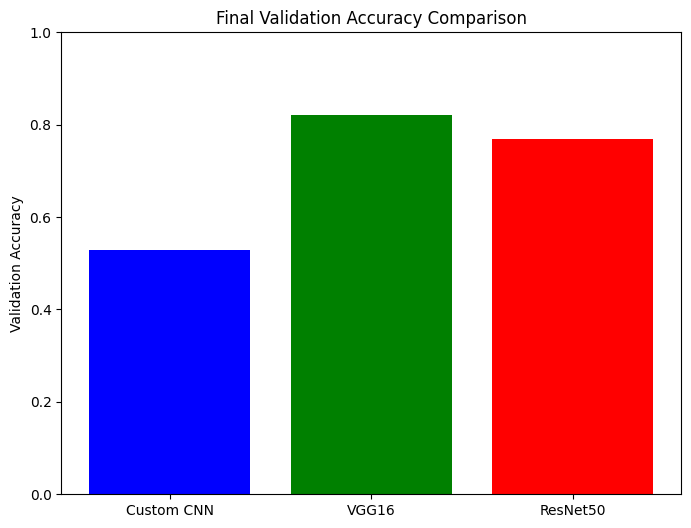

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
model_names = ['Custom CNN', 'VGG16', 'ResNet50']
accuracies = [cnn_val_acc, vgg_val_acc, resnet_val_acc]
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
plt.ylabel('Validation Accuracy')
plt.title('Final Validation Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

# 12:Define the Common Function For confusioin Matrixs


In [ ]:
def get_preds(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return all_preds, all_labels
def plot_confusion_matrix(model, loader, model_name):
    preds, labels = get_preds(model, loader)
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


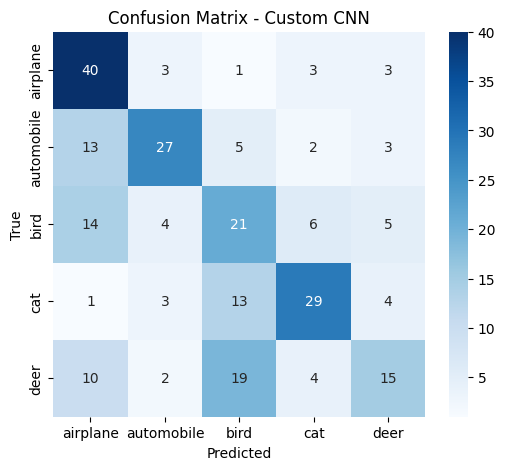

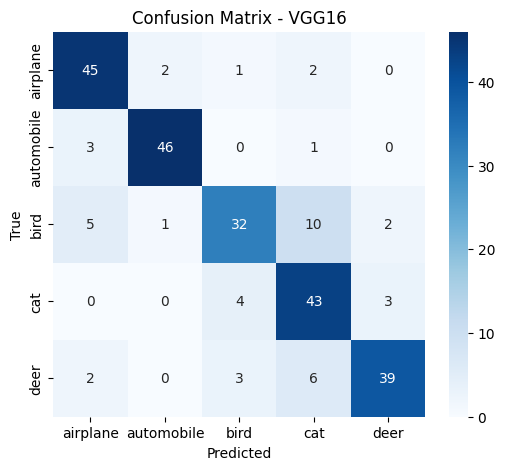

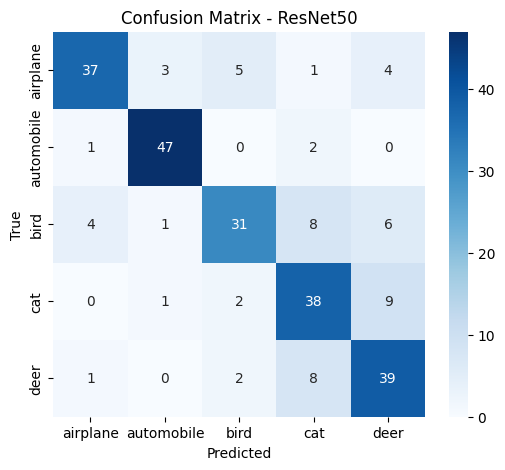

In [ ]:
# Make sure the models are loaded and moved to device
cnn_model.eval()
vgg_model.eval()
resnet_model.eval()

# Plot for CNN
plot_confusion_matrix(cnn_model, test_loader, "Custom CNN")

# Plot for VGG16
plot_confusion_matrix(vgg_model, test_loader, "VGG16")

# Plot for ResNet50
plot_confusion_matrix(resnet_model, test_loader, "ResNet50")


# Final Report:
## Introduction
This report summarizes the implementation and evaluation of three convolutional neural network
(CNN) models for image classification on a custom dataset consisting of five classes. The models
evaluated are:
- A custom CNN built from scratch
- Transfer learning using VGG16
- Transfer learning using ResNet50
## Dataset Overview
The dataset is organized into separate training and testing folders. Each folder contains five
subdirectories representing class labels, with 200`.png` images corresponding to each class. Images
were resized to 224x224 pixels and normalized appropriately.
Model Architectures
## **Custom CNN:**
- 3 Convolutional Layers with ReLU and MaxPooling
- Flatten Layer
- Fully Connected
- Softmax Output Layer
## **VGG16 (Transfer Learning):**
- Pretrained VGG16 model with frozen convolutional base
- Final fully connected layer replaced with a new Linear layer matching the number of classes
## **ResNet50 (Transfer Learning):**
- Pretrained ResNet50 with frozen base layers
- Final fully connected layer replaced with a new Linear layer
## Training Setup
Optimizer: Adam (learning rate = 0.001)
Loss Function: CrossEntropyLoss
Batch Size: 32
Epochs: 5 for CNN , ResNet and for VGG16
Device: GPU (if available)
## Evaluation Metrics
Accuracy (Training and Validation)
Confusion Matrix
Results Summary

Model | Train Accuracy | Validation Accuracy
-------------|----------------|----------------------
Custom CNN | 0.63 | 0.52
VGG16 | 0.91 | 0.82
ResNet50 | 0.85 | 0.76

## Confusion Matrices
Confusion matrices for all models were generated and visually compared to identify misclassification
patterns. The VGG16 model showed the most distinct and accurate classification across all classes.
